# Content
## 1. Load Data
## 2. Data Processing
## 3. Model Building
## 4. Feature Analysis
## 5. Best Model Accuracy on Test Set
## 6. Sensitivity Analysis
## 7. Prediction
## 8. Failure Analy

# **1. Load Data**

In [1]:
import pandas as pd
import numpy as np
import regex as re
import statistics
from collections import Counter
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from collections import defaultdict
import textblob
import string
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xinfengliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# load data
df = pd.read_csv('WikiLarge_Train.csv')
X_pred = pd.read_csv('WikiLarge_Test.csv')

<AxesSubplot:>

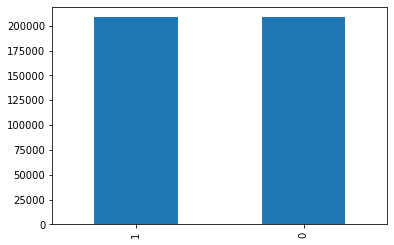

In [3]:
# check dataset balance
df['label'].value_counts().plot(kind='bar')

# **2. Data Processing**

## 2.1 Change data to lower case

In [4]:
data = [df, X_pred]
for data_set in data:
    data_set['modified_txt'] = data_set['original_text']
    data_set['modified_txt'] = data_set['modified_txt'].str.lower()
    data_set['original_text'] = data_set['original_text'].str.lower()

## 2.2 Delete Punctuation

In [5]:
for data_set in data:
    data_set['modified_txt'] = data_set['modified_txt'].str.replace(r'[^\w\s]+', '')
    data_set['original_text'] = data_set['original_text'].str.replace(r'[^\w\s]+', '')

/var/folders/8_/j14vrxnx2cz8yhy96kx5x_3h0000gn/T/ipykernel_14426/1386160760.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_set['modified_txt'] = data_set['modified_txt'].str.replace(r'[^\w\s]+', '')
/var/folders/8_/j14vrxnx2cz8yhy96kx5x_3h0000gn/T/ipykernel_14426/1386160760.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data_set['original_text'] = data_set['original_text'].str.replace(r'[^\w\s]+', '')


## 2.3 Remove Stop Words

In [6]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

for data_set in data:
    data_set['modified_txt'] = data_set['modified_txt'].apply(lambda x: ' '.join([word for word in x.split() if not word in stop]))
    
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinfengliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.4 Create Text/NLP Based Features

2.4.1 Char/Word Count

In [7]:
for data_set in data:
    data_set['char_count'] = data_set['original_text'].apply(len)
    data_set['word_count'] = data_set['original_text'].apply(len)
    data_set['word_density'] = data_set['char_count'] / (data_set['word_count']+1)

#### Word Count Plot

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

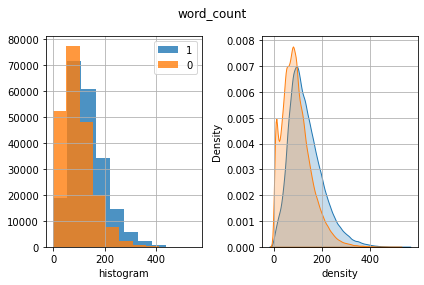

In [8]:
x, y = "word_count", "label"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.tight_layout()
plt.show()

#### Char-Count Plot

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

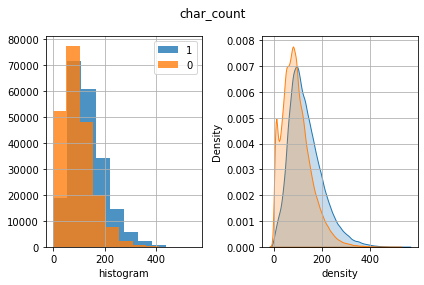

In [9]:
x, y = "char_count", "label"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.tight_layout()
plt.show()

#### Word Density Plot

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

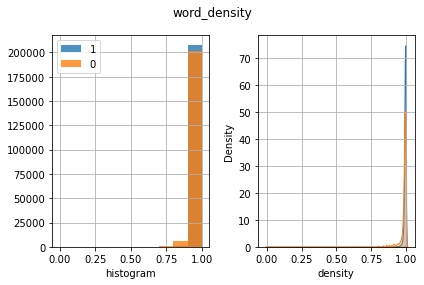

In [10]:
x, y = "word_density", "label"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.tight_layout()
plt.show()

### 2.4.2 Speech Tag Count

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

for data_set in data:
    token = []
    for each in tqdm(list(data_set['original_text'])):
        token.append(word_tokenize(each))
    data_set['token'] = token

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xinfengliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/xinfengliu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/xinfengliu/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
100%|█████████████████████████████████| 119092/119092 [00:16<00:00, 7196.11it/s]


In [12]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

for data_set in data:
    data_set['lemma'] = data_set['token'].apply(lambda x: [wordnet_lemmatizer.lemmatize(each) for each in x])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xinfengliu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
for data_set in data:
    noun = []
    verb = []
    adj = []
    adv = []
    for each in tqdm(list(data_set['token'])):
        tag = nltk.pos_tag(each, tagset='universal')
        tag_ct = defaultdict(int)
        for i in range(len(tag)):
            word_type = tag[i][1]
            tag_ct[word_type] += 1
        noun.append(tag_ct['NOUN'])
        verb.append(tag_ct['VERB'])
        adj.append(tag_ct['ADJ'])
        adv.append(tag_ct['ADV'])
    data_set['noun_count'] = noun
    data_set['verb_count'] = verb
    data_set['adj_count'] = adj
    data_set['adv_count'] = adv

100%|█████████████████████████████████| 119092/119092 [01:38<00:00, 1205.27it/s]


## 2.5 Create Basic Words Count Feature

In [14]:
# read simple words data
simple_words = pd.read_csv('dale_chall.txt')
simple_words = simple_words.rename(columns={'a': 'words'})
simp_word_ls = simple_words['words'].tolist()
simp_word_ls = [each.lower() for each in simp_word_ls]

In [15]:
def simp_word_ct(x):
    """
    input: a sentence in string fromat
    
    output: percentage of simple words in the sentence
    """
    words = word_tokenize(x)
    counter = 0
    for i in words:
        if i in simp_word_ls:
            counter += 1
    try:
        simple_percent = counter/(len(words))
    except ZeroDivisionError:
        simple_percent = -1
    return simple_percent

# df['simp_word_percent'] = df['original_text'].apply(lambda x: simp_word_ct(x))

for data_set in data:
    data_set['simp_word_percent'] = data_set['original_text'].apply(lambda x: simp_word_ct(x))

In [16]:
def stop_word_ct(x):
    """
    input: a sentence in string fromat
    
    output: percentage of stop words in the sentence
    """
    #words = word_tokenize(x)
    words = x
    counter = 0
    for i in words:
        if i in stop:
            counter += 1
    stop_percent = counter/(len(words)+1)
    return stop_percent

for data_set in data:
    data_set['stop_word_percent'] = data_set['lemma'].apply(lambda x: stop_word_ct(x))

## 2.5.1 Average Word Difficuly

AoA_51715_words.csv

In [17]:
aoa_words = pd.read_csv('AoA_51715_words.csv',encoding = "ISO-8859-1")

## 2.5.2 Concreteness ratings

In [18]:
concrete = pd.read_csv('concretness.csv')

In [19]:
age_dict = dict(zip(aoa_words['Word'],aoa_words['AoA_Kup_lem']))
perc_dict = dict(zip(aoa_words['Word'],aoa_words['Perc_known_lem']))

age_mean = np.mean(aoa_words['AoA_Kup_lem'])
perc_mean = np.mean(aoa_words['Perc_known_lem'])

concrete_dict = dict(zip(concrete['Word'],concrete['Conc.M']))
concrete_mean = np.mean(concrete['Conc.M'])


In [20]:
for data_set in data:
    avg_age_list = []
    avg_per_list = []
    avg_concrete_list = []
    for each in tqdm(list(data_set['lemma'])):
        total_age = 0
        total_percent = 0
        total_concrete = 0
        for each_word in each:
            if age_dict.get(each_word):
                age = age_dict.get(each_word)
            else:
                age = age_mean
            total_age += age
            
            if perc_dict.get(each_word):
                percent = perc_dict.get(each_word)
            else:
                percent = perc_mean
            total_percent += percent
            
            if concrete_dict.get(each_word):
                concrete_score = concrete_dict.get(each_word)
            else:
                concrete_score = concrete_mean
            total_concrete += concrete_score
        
        if len(each) != 0:
            avg_age = total_age / len(each)
            avg_percent = total_percent / len(each)
            avg_concrete = total_concrete / len(each)
        else:
            avg_age = age_mean
            avg_percent = perc_mean
            avg_concrete = concrete_mean
        avg_age_list.append(avg_age)
        avg_per_list.append(avg_percent)
        avg_concrete_list.append(avg_concrete)
        
    data_set['age'] = avg_age_list
    data_set['percent_know'] = avg_per_list
    data_set['concreteness'] = avg_concrete_list

100%|████████████████████████████████| 119092/119092 [00:02<00:00, 50568.30it/s]


## 2.6 Count of number

In [21]:
for data_set in data:
    num_percent_list = []
    for each in tqdm(list(data_set['token'])):
        num_cnt = 0
        for each_word in each:
            if each_word.isdigit() == True:
                num_cnt += 1
        
        if len(each) != 0:
            number_per = num_cnt / len(each)
        else:
            number_per = 0
        
        num_percent_list.append(number_per)
    
    data_set['num'] = num_percent_list

100%|███████████████████████████████| 119092/119092 [00:00<00:00, 411149.55it/s]


## 2.7 Upper case

In [22]:
X_pred = X_pred.drop(columns=['id', 'label' ])

In [23]:
X = df.drop(columns = ['label'])
y = df['label']

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.85, random_state=1)

## The number of top 100 and least 1000 words

In [25]:
total_token = []
for each in tqdm(X_train['lemma']):
    each = [each_word for each_word in each if each_word not in stop and not each_word.isdigit()]
    total_token += each

counts = Counter(total_token)

sorted_x = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True)[0:100])
sorted_x_reverse = dict(sorted(counts.items(), key=lambda item: item[1])[0:1000])

top100list = list(sorted_x.keys())
least_1000_list = list(sorted_x_reverse.keys())

X_train['top100'] = X_train['lemma'].apply(lambda x: len([w for w in x if w in top100list]))
X_test['top100'] = X_test['lemma'].apply(lambda x: len([w for w in x if w in top100list]))

X_train['least1000'] = X_train['lemma'].apply(lambda x: len([w for w in x if w in least_1000_list]))
X_test['least1000'] = X_test['lemma'].apply(lambda x: len([w for w in x if w in least_1000_list]))

100%|████████████████████████████████| 354252/354252 [00:12<00:00, 27784.74it/s]


In [26]:
total_token = []
for each in tqdm(X_pred['lemma']):
    each = [each_word for each_word in each if each_word not in stop and not each_word.isdigit()]
    total_token += each
    
counts = Counter(total_token)

sorted_x = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True)[0:100])
sorted_x_reverse = dict(sorted(counts.items(), key=lambda item: item[1])[0:1000])
top100list = list(sorted_x.keys())
least_1000_list = list(sorted_x_reverse.keys())

X_pred['top100'] = X_pred['lemma'].apply(lambda x: len([w for w in x if w in top100list]))

X_pred['least1000'] = X_pred['lemma'].apply(lambda x: len([w for w in x if w in least_1000_list]))

X_pred.drop(columns=['lemma'],inplace = True)

100%|████████████████████████████████| 119092/119092 [00:04<00:00, 28128.44it/s]


## 2.8 Text Based Features

In [27]:
X_train_text = X_train['modified_txt']
X_test_text = X_test['modified_txt']
X_pred_text = X_pred['modified_txt']

### 2.8.1 TFIDF Text Based Feature

In [28]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=500)
tfidf_vect.fit(X_train['modified_txt'])
X_train_tfidf = tfidf_vect.transform(X_train_text)
X_test_tfidf = tfidf_vect.transform(X_test_text)
X_pred_tfidf = tfidf_vect.transform(X_pred_text)

In [29]:
tdidf_df_train = pd.DataFrame(X_train_tfidf.todense())
tdidf_df_test = pd.DataFrame(X_test_tfidf.todense())
tdidf_df_pred = pd.DataFrame(X_pred_tfidf.todense())

## 2.9 Combined Features

### 2.9.1 TFIDF Combined

In [30]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_pred = X_pred.fillna(0)

In [31]:
X_train.reset_index(drop=True, inplace=True)
tdidf_df_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
tdidf_df_test.reset_index(drop=True, inplace=True)

X_pred.reset_index(drop=True, inplace=True)
tdidf_df_pred.reset_index(drop=True, inplace=True)

combined_X_train = pd.concat([X_train, tdidf_df_train], axis=1)
combined_X_test = pd.concat([X_test, tdidf_df_test], axis=1)
combined_X_pred = pd.concat([X_pred, tdidf_df_pred], axis=1)

In [32]:
combined_X_train.drop(columns = ['original_text','modified_txt','token','lemma'],inplace = True)
combined_X_test.drop(columns = ['original_text','modified_txt','token','lemma'],inplace = True)

X_train.drop(columns = ['original_text','modified_txt','token','lemma'],inplace = True)
X_test.drop(columns = ['original_text','modified_txt','token','lemma'],inplace = True)

X_pred.drop(columns=['original_text', 'modified_txt', 'token'], inplace = True)
combined_X_pred.drop(columns=['original_text', 'modified_txt', 'token'], inplace = True)

# 3. Model Building

### (1). Standardiazation

In [33]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
scaler2 = preprocessing.MinMaxScaler().fit(combined_X_train)
combined_X_train = scaler2.transform(combined_X_train)
combined_X_test = scaler2.transform(combined_X_test)
combined_X_pred = scaler2.transform(combined_X_pred)

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warning

### (2). Dummy Classifier

In [35]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier().fit(X_train_scaled, y_train)
dummy_cv_score = cross_val_score(dummy_clf, X_train_scaled, y_train, cv=5)
print('Cross Validation Score of Dummy classifier on training set: {:.3f}'
      .format(dummy_cv_score.mean()))

Cross Validation Score of Dummy classifier on training set: 0.500


In [36]:
dummy_clf_tfidf = DummyClassifier().fit(tdidf_df_train, y_train)
dummy_TFIDF_score = cross_val_score(dummy_clf_tfidf, tdidf_df_train, y_train, cv=5)
print('Cross Validation Score of Dummy classifier on TFIDF training set: {:.3f}'
      .format(dummy_TFIDF_score.mean()))

Cross Validation Score of Dummy classifier on TFIDF training set: 0.500


In [37]:
dummy_clf_comb = DummyClassifier().fit(combined_X_train, y_train)
dummy_score_comb = cross_val_score(dummy_clf_comb, combined_X_train, y_train, cv=5)
print('Cross Validation Score of Dummy classifier on Combined Features training set: {:.3f}'
      .format(dummy_score_comb.mean()))

Cross Validation Score of Dummy classifier on Combined Features training set: 0.500


### (3). Logistic Regression Classifier

In [38]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(max_iter=500).fit(X_train_scaled, y_train)
log_cv_score = cross_val_score(log_clf, X_train_scaled, y_train, cv=5)
print('Cross Validation Score of Logistic Regression classifier on training set: {:.3f}'
      .format(log_cv_score.mean()))

Cross Validation Score of Logistic Regression classifier on training set: 0.639


In [39]:
log_clf_tfidf = LogisticRegression().fit(tdidf_df_train, y_train)
log_cv_score_tfidf = cross_val_score(log_clf_tfidf, tdidf_df_train, y_train, cv=5)
print('Cross Validation Score of Logistic Regression classifier on TFIDF training set: {:.3f}'
      .format(log_cv_score_tfidf.mean()))

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Cross Validation Score of Logistic Regression classifier on TFIDF training set: 0.628


In [40]:
log_clf_comb = LogisticRegression(max_iter=500).fit(combined_X_train, y_train)
log_cv_score_comb = cross_val_score(log_clf_comb, combined_X_train, y_train, cv=5)
print('Cross Validation Score of Logistic Regression classifier on Combined Feature training set: {:.3f}'
      .format(log_cv_score_comb.mean()))

Cross Validation Score of Logistic Regression classifier on Combined Feature training set: 0.667


### (5). KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier().fit(X_train_scaled, y_train)
knn_cv_score = cross_val_score(knn_clf, X_train_scaled, y_train, cv=5)
print('Cross Validation Score of KNN classifier on training set: {:.3f}'
      .format(knn_cv_score.mean()))

Cross Validation Score of KNN classifier on training set: 0.640


In [42]:
knn_clf_tfidf = KNeighborsClassifier().fit(tdidf_df_train, y_train)
knn_cv_score_tfidf = cross_val_score(knn_clf_tfidf, tdidf_df_train, y_train, cv=5)
print('Cross Validation Score of KNN classifier on TFIDF training set: {:.3f}'
      .format(knn_cv_score_tfidf.mean()))

Cross Validation Score of KNN classifier on TFIDF training set: 0.565


In [43]:
knn_clf_comb = KNeighborsClassifier().fit(combined_X_train, y_train)
knn_cv_score_comb= cross_val_score(knn_clf_comb, combined_X_train, y_train, cv=5)
print('Cross Validation Score of KNN classifier on Combined Features training set: {:.3f}'
      .format(knn_cv_score_comb.mean()))

Cross Validation Score of KNN classifier on Combined Features training set: 0.603


### (6). Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier().fit(X_train_scaled, y_train)
dt_cv_score = cross_val_score(dt_clf, X_train_scaled, y_train, cv=5)
print('Cross Validation Score of Decision Tree classifier on training set: {:.3f}'
      .format(dt_cv_score.mean()))

Cross Validation Score of Decision Tree classifier on training set: 0.654


In [45]:
dt_clf_tfidf = DecisionTreeClassifier().fit(tdidf_df_train, y_train)
dt_cv_score_tfidf = cross_val_score(dt_clf_tfidf, tdidf_df_train, y_train, cv=5)
print('Cross Validation Score of Decision Tree classifier on TFIDF training set: {:.3f}'
      .format(dt_cv_score_tfidf.mean()))

Cross Validation Score of Decision Tree classifier on TFIDF training set: 0.618


In [46]:
dt_clf_comb = DecisionTreeClassifier().fit(combined_X_train, y_train)
dt_cv_score_comb = cross_val_score(dt_clf, combined_X_train, y_train, cv=5)
print('Cross Validation Score of Decision Tree classifier on Combined Feature training set: {:.3f}'
      .format(dt_cv_score_comb.mean()))

Cross Validation Score of Decision Tree classifier on Combined Feature training set: 0.666


### (7). Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf_clf = RandomForestClassifier().fit(X_train_scaled,y_train)
rf_cv_score = cross_val_score(rf_clf, X_train_scaled, y_train, cv=5)
print('Cross Validation Score of Random Forest classifier on training set: {:.3f}'
      .format(rf_cv_score.mean()))

Cross Validation Score of Random Forest classifier on training set: 0.700


In [48]:
rf_clf_tfidf = RandomForestClassifier().fit(tdidf_df_train,y_train)
rf_cv_score_tfidf = cross_val_score(rf_clf_tfidf, tdidf_df_train, y_train, cv=5)
print('Cross Validation Score of Random Forest classifier on TFIDF training set: {:.3f}'
      .format(rf_cv_score_tfidf.mean()))

Cross Validation Score of Random Forest classifier on TFIDF training set: 0.630


In [49]:
rf_clf_comb = RandomForestClassifier().fit(combined_X_train,y_train)
rf_cv_score_comb = cross_val_score(rf_clf_comb, combined_X_train, y_train, cv=5)
print('Cross Validation Score of Random Forest classifier on Combined Features training set: {:.3f}'
      .format(rf_cv_score_comb.mean()))

Cross Validation Score of Random Forest classifier on Combined Features training set: 0.709


### (8). AdaBoost

In [50]:
from sklearn.ensemble import AdaBoostClassifier
adb_clf = AdaBoostClassifier().fit(X_train_scaled, y_train)
adb_cv_score = cross_val_score(adb_clf, X_train_scaled, y_train, cv=5)
print('Cross Validation Score of AdaBoosting classifier on training set: {:.3f}'
      .format(adb_cv_score.mean()))

Cross Validation Score of AdaBoosting classifier on training set: 0.644


In [51]:
adb_clf_tfidf = AdaBoostClassifier().fit(tdidf_df_train, y_train)
adb_cv_score_tfidf = cross_val_score(adb_clf_tfidf, tdidf_df_train, y_train, cv=5)
print('Cross Validation Score of AdaBoosting classifier on TFIDF training set: {:.3f}'
      .format(adb_cv_score_tfidf.mean()))

Cross Validation Score of AdaBoosting classifier on TFIDF training set: 0.598


In [52]:
adb_clf_comb = AdaBoostClassifier().fit(combined_X_train, y_train)
adb_cv_score_comb = cross_val_score(adb_clf_comb, combined_X_train, y_train, cv=5)
print('Cross Validation Score of AdaBoosting classifier on Combined Features training set: {:.3f}'
      .format(adb_cv_score_comb.mean()))

Cross Validation Score of AdaBoosting classifier on Combined Features training set: 0.658


### (9). XGBoost

In [53]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier().fit(X_train_scaled, y_train)
xgb_cv_score = cross_val_score(xgb_clf, X_train_scaled, y_train, cv=5)
print('Cross Validation Score of XGBoosting classifier on training set: {:.3f}'
      .format(xgb_cv_score.mean()))

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:52:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:53:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:53:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:53:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:54:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:54:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross Validation Score of XGBoosting classifier on training set: 0.663


In [54]:
xgb_clf_tfidf = xgb.XGBClassifier().fit(tdidf_df_train, y_train)
xgb_cv_score_tfidf = cross_val_score(xgb_clf_tfidf, tdidf_df_train, y_train, cv=5)
print('Cross Validation Score of XGBoosting classifier on training set: {:.3f}'
      .format(xgb_cv_score_tfidf.mean()))

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:01:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:07:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:12:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:18:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:23:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross Validation Score of XGBoosting classifier on training set: 0.636


In [55]:
xgb_clf_comb = xgb.XGBClassifier().fit(combined_X_train, y_train)
xgb_cv_score_comb = cross_val_score(xgb_clf_comb, combined_X_train, y_train, cv=5)
print('Cross Validation Score of XGBoosting classifier on training set: {:.3f}'
      .format(xgb_cv_score_comb.mean()))

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:29:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:53:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross Validation Score of XGBoosting classifier on training set: 0.684


### (10). Deep Learning

#### (1) Combined Features

In [56]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Flatten, SimpleRNN
from keras import preprocessing
import tensorflow as tf
from keras import optimizers

In [57]:
dl = Sequential()
dl.add(Dense(515, input_dim=515, activation='relu'))
dl.add(Dense(800, activation='relu'))
dl.add(Dense(400, activation='relu'))
dl.add(Dense(218, activation='relu'))
dl.add(Dense(1, activation='sigmoid'))
dl.compile(optimizer=optimizers.Adam(learning_rate=0.001),
           loss='binary_crossentropy',
           metrics=['acc'])


2021-12-12 11:05:02.180466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [58]:
kf = KFold(n_splits = 5)
acc = []
val_acc = []
loss = []
val_loss = []
fold_no = 1
for train_idx, test_idx in kf.split(combined_X_train):
    X_tra = combined_X_train[train_idx[0]:train_idx[len(train_idx)-1]]
    X_vlid = combined_X_train[test_idx[0]:test_idx[len(test_idx)-1]]
    y_tra = y_train[train_idx[0]:train_idx[len(train_idx)-1]]
    y_vlid = y_train[test_idx[0]:test_idx[len(test_idx)-1]]
    
    X_tra = np.asarray(X_tra)
    X_vlid = np.asarray(X_vlid)
    y_tra = np.asarray(y_tra)
    y_vlid = np.asarray(y_vlid)
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = dl.fit(x=X_tra, y=y_tra, epochs=10, validation_data=(X_vlid, y_vlid))
    accracy_perfold = statistics.mean(history.history['acc'])
    loss_perfild = statistics.mean(history.history['loss'])
    print(f'Score for fold {fold_no}: Accuracy of {accracy_perfold}; Loss of {loss_perfild}')
    acc.append(statistics.mean(history.history['acc']))
    val_acc.append(statistics.mean(history.history['val_acc']))
    loss.append(statistics.mean(history.history['loss']))
    val_loss.append(statistics.mean(history.history['val_loss']))
    
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...


2021-12-12 11:05:03.531010: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
8857/8857 [==============================] - 51s 6ms/step - loss: 0.6061 - acc: 0.6561 - val_loss: 0.5870 - val_acc: 0.6710
Epoch 2/10
8857/8857 [==============================] - 49s 6ms/step - loss: 0.5789 - acc: 0.6780 - val_loss: 0.5812 - val_acc: 0.6754
Epoch 3/10
8857/8857 [==============================] - 50s 6ms/step - loss: 0.5656 - acc: 0.6910 - val_loss: 0.5819 - val_acc: 0.6779
Epoch 4/10
8857/8857 [==============================] - 48s 5ms/step - loss: 0.5536 - acc: 0.7007 - val_loss: 0.5875 - val_acc: 0.6796
Epoch 5/10
8857/8857 [==============================] - 50s 6ms/step - loss: 0.5364 - acc: 0.7138 - val_loss: 0.5863 - val_acc: 0.6762
Epoch 6/10
8857/8857 [==============================] - 49s 6ms/step - loss: 0.5208 - acc: 0.7253 - val_loss: 0.5953 - val_acc: 0.6734
Epoch 7/10
8857/8857 [==============================] - 49s 6ms/step - loss: 0.5024 - acc: 0.7372 - val_loss: 0.6097 - val_acc: 0.6691
Epoch 8/10
8857/8857 [==============================] -

In [59]:
print('Cross Validation Score of Deep Learning classifier on Combined Features training set: {:.3f}'
      .format(statistics.mean(acc)))

Cross Validation Score of Deep Learning classifier on Combined Features training set: 0.807


### (11). Result on Training Set Using 5 Fold Cross Validation

| Molde/Accuracy | Dummy Classifier | Logistic Regression | KNN | Decision Tree | Random Forest | AdaBoost | XGBoost| Deep Learning |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Stats Features Based Acc | 0.500 | 0.638 | 0.640 | 0.654 | 0.701 | 0.644 | 0.663| NA |
| Text Features Based Acc | 0.500 | 0.628 | 0.564 | 0.617 | 0.629 | 0.598 | 0.636 | NA |
| Combined Features Acc | 0.500 | 0.667 | 0.603 | 0.666 | 0.709 | 0.658 | 0.684| 0.810 |


# 4. Feature Analysis

In [62]:
feature_names = X_train.columns.tolist()
c_features = len(X_train.columns.tolist())

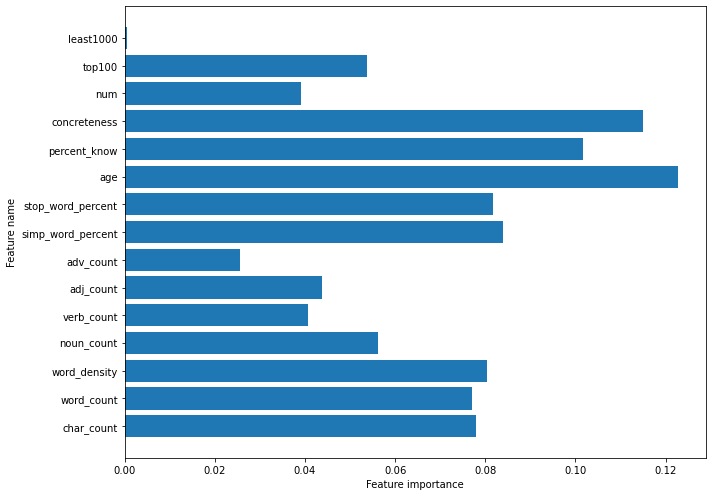

In [63]:
plt.figure(figsize=(10,7))
plt.barh(range(c_features), rf_clf.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), feature_names)
plt.tight_layout()
plt.show()

# 5. Best Model Accuracy on Test Set

## (1). Deep Learning

In [65]:
y_test_hat = dl.predict(combined_X_test)
y_test_hat = y_test_hat.flatten().tolist()
y_test_hat = [round(num) for num in y_test_hat]
y_label = y_test.tolist()

count = 0
for i in range(len(y_test)):
    if y_label[i] == y_test_hat[i]:
        count += 1
acc = count/len(y_test)

print('Accuracy on test set is: ', round(acc, 3))

Accuracy on test set is:  0.655


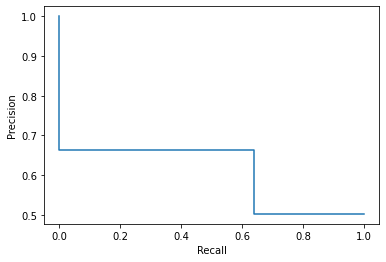

In [66]:
precision, recall, _ = precision_recall_curve(y_label, y_test_hat)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## (2). Random Forest

In [68]:
y_pred_rf = rf_clf_comb.predict(combined_X_test)
y_pred_rf = y_pred_rf.tolist()
y_label = y_test.tolist()
count = 0

for i in range(len(y_label)):
    if y_label[i] == y_pred_rf[i]:
        count += 1

acc = count/len(y_test)

print('Accuracy on test set is: ', round(acc, 3))

Accuracy on test set is:  0.715


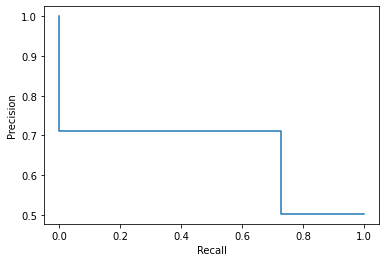

In [69]:
precision, recall, _ = precision_recall_curve(y_label, y_pred_rf)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

# 6. Sensitivity Analysis


In [71]:
max_features = [3, 5, 7, 9, 12]
socres = []
for i in tqdm(max_features):
    rf_clf = RandomForestClassifier(max_features=i).fit(X_train_scaled, y_train)
    y_pred_rf = rf_clf.predict(X_test_scaled)
    y_pred_rf = y_pred_rf.tolist()
    y_label = y_test.tolist()
    count = 0
    for i in range(len(y_label)):
        if y_label[i] == y_pred_rf[i]:
            count += 1
    acc = count/len(y_test)
    socres.append(acc)

100%|████████████████████████████████████████████| 5/5 [14:40<00:00, 176.17s/it]


Text(0.5, 1.0, 'Accuracy of Different max_features')

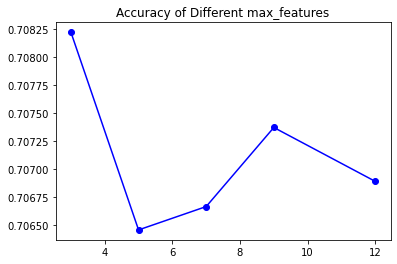

In [72]:
plt.plot(max_features, socres, marker='o', color='b')
plt.title('Accuracy of Different max_features')

# 7. Prediction

In [73]:
y_pred = rf_clf_comb.predict(combined_X_pred)

In [74]:
result = pd.read_csv('WikiLarge_Test.csv')
result['label'] = y_pred
result = result.drop(columns=['original_text'])

In [75]:
result.to_csv('result.csv', index=False)

# 8. Failure Analysis

In [76]:
y_pred_rf_df = pd.DataFrame(data={'y_hat': y_pred_rf})
y_pred_rf_df.reset_index(drop=True, inplace=True)

text = pd.DataFrame(data={'text': X_test_text})
text.reset_index(drop=True, inplace=True)

num_feature = X_test.copy()

label_df = pd.DataFrame(data={'label': y_test})
label_df.reset_index(drop=True, inplace=True)

analysis = pd.concat([text, num_feature, label_df, y_pred_rf_df], axis=1)

In [77]:
fauilre = analysis.loc[analysis['label']!=analysis['y_hat']]
fauilre

,text,char_count,word_count,word_density,noun_count,verb_count,adj_count,adv_count,simp_word_percent,stop_word_percent,age,percent_know,concreteness,num,top100,least1000,label,y_hat
0,yarra trams fleet consists 500 trams operated ...,100,100,0.990099,5,3,1,0,0.375000,0.235294,7.622068,0.966710,2.793367,0.062500,2,0,0,1
1,still life concept album explained åkerfeldt m...,190,190,0.994764,9,8,2,1,0.685714,0.500000,5.802704,0.991744,2.320610,0.000000,2,0,1,0
2,romana short romanadvoratrelundar fictional ch...,125,125,0.992063,8,1,3,0,0.411765,0.333333,6.237920,0.983002,2.704635,0.000000,2,0,0,1
3,minor scale music theory scale least three sca...,164,164,0.993939,8,3,6,0,0.548387,0.437500,6.475534,0.992054,2.714073,0.000000,3,0,0,1
4,show also created character frasier crane,50,50,0.980392,4,1,0,1,0.500000,0.222222,6.440193,0.987960,2.792817,0.000000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62507,time death still october 2008 sixth oldest per...,181,181,0.994505,10,4,5,1,0.735294,0.428571,6.093848,0.977228,2.675188,0.029412,5,0,0,1
62509,made number materials including ceramics glass,71,71,0.986111,4,4,0,0,0.692308,0.500000,5.310769,0.987692,2.852308,0.000000,3,0,1,0
62510,un secretary general thant began serving actin...,243,243,0.995902,10,6,3,3,0.540541,0.342105,7.195199,0.959715,2.577369,0.054054,2,0,0,1
62512,keynes brother sir geoffrey keynes lrb 1887 19...,108,108,0.990826,9,3,0,0,0.235294,0.166667,8.870909,0.940400,3.003098,0.117647,3,0,0,1


In [78]:
fauilre[fauilre.duplicated()].sort_values(by=['text']).head(20)

,text,char_count,word_count,word_density,noun_count,verb_count,adj_count,adv_count,simp_word_percent,stop_word_percent,age,percent_know,concreteness,num,top100,least1000,label,y_hat
58001,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
26169,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
19411,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
29407,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
37433,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
14295,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
10850,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
52551,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
22075,,0,0,0.000000,0,0,0,0,-1.000000,0.000000,10.361546,0.903680,3.036267,0.000000,0,0,1,0
46353,10243 kg neptune mass puts planet earth larges...,156,156,0.993631,11,2,4,1,0.500000,0.344828,7.137640,0.965469,2.926300,0.035714,1,0,0,1
